In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import re
import sqlite3
from datetime import datetime
from pandas import Series, DataFrame
sns.set()
%matplotlib inline
!pip install fuzzywuzzy

In [0]:
from fuzzywuzzy import fuzz

# Cleaning the data

## Introduction to the data

In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
off = pd.read_csv('/content/drive/My Drive/EPFL/ma1/ADA/Ada Project/OpenFoodFacts.csv', sep='\t', low_memory=False)

This is a dataset of food products listing the ingredients and nutritional facts of more than 1,000,000 foods from over 150 countries in the world.
The data is meant to be free to the public to help users decode food labels, and make better food choices in general.
The dataset contains more than 1,000,000 rows over 175 columns. However, as we will see there are a lot of missing or obviously incorrect values.
- fields that end with _tags are comma-separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
- fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
- fields that end with _100g correspond to the amount of a nutrient (in g, or kJ for energy) for 100 g or 100 ml of product
- fields that end with _serving correspond to the amount of a nutrient (in g, or kJ for energy) for 1 serving of the product
- nutrition-score-fr_100g : experimental nutrition score derived from the UK FSA score and adapted for the French market (these fields are of numeric, ranging from -15 to 40. The lower the score, the better)
- nutrition-score-uk_100g : nutrition score defined by the UK Food Standards Administration (these fields are of numeric, ranging from -15 to 40. The lower the score, the better)
- nutrition_grade_fr_100g : Seems to be a simple categorization of the score into A, B, C, D, and E

In [114]:
print('There are {:,} rows '.format(len(off)) + 'and {} columns in our data'.format(off.shape[1]))

There are 1,013,901 rows and 175 columns in our data


In [0]:
off.set_index('code', inplace=True)

## Dealing with missing values

In [116]:
off.isna().sum()

url                         0
creator                     3
created_t                   0
created_datetime            1
last_modified_t             0
                       ...   
choline_100g          1013870
phylloquinone_100g    1013897
beta-glucan_100g      1013881
inositol_100g         1013864
carnitine_100g        1013886
Length: 174, dtype: int64

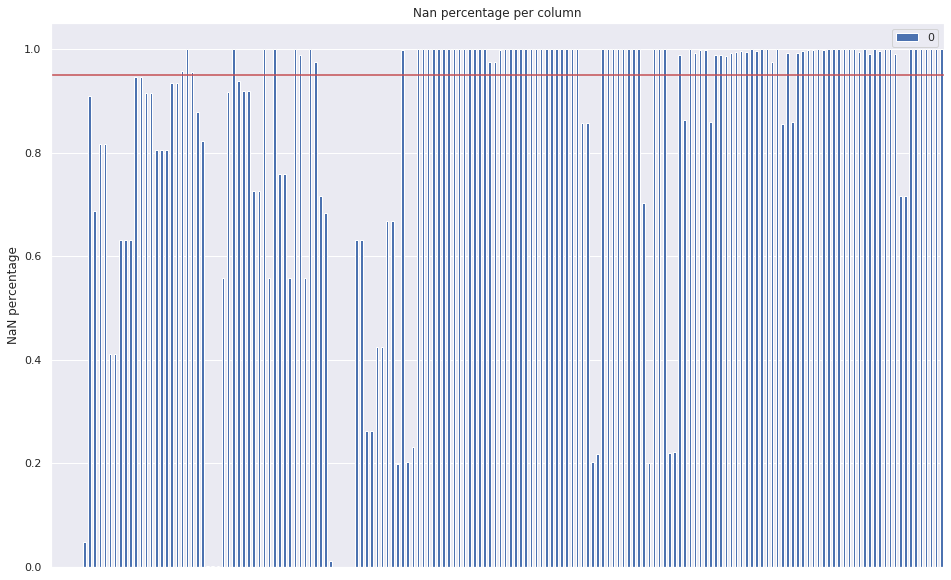

In [117]:
count_nan = off.isna().sum()/len(off)

pl = pd.DataFrame(count_nan).plot(kind="bar", figsize=(16, 10))
plt.xticks([])
pl.set_ylabel("NaN percentage")
pl.set_title("Nan percentage per column")
pl.axhline(y=0.95, color='r', linestyle='-')

We can clearly see that many features have more than 95% of data that is missing. Some columns have up to a 100% of null data.Thus, we decide to drop columns that have more than 95% missing values. 
We still need to have enough values in each column for the analysis to be statistically significant. We calculate the significant sample size (for a confidence level of 99% and a confidence interval of 1, for our population of 1'013'901) by using the following formula : 
$$sample \: size = \dfrac{\dfrac{z^2p(1-p)}{e^2}}{1 + (\dfrac{z^2p(1-p)}{e^2N})} = 16372$$

with z=z_score, e=confidence interval, p=0.5, N=population size, 

5% of the population size is greater than 16372. Thus 95% is a valid threshold for our study.



In [0]:
off = off.dropna(axis=1, thresh= len(off)*0.05, how='all')


In [119]:
print('There are now {:,} rows '.format(len(off)) + 'and {} columns left in our data'.format(off.shape[1]))

There are now 1,013,901 rows and 74 columns left in our data


## Selecting relevant data

We then decide to remove the columns that will not be useufull in our analysis.

In [0]:
off = off.drop(columns=['url',
                        'generic_name',
                        'quantity',
                        'origins_tags',
                        'manufacturing_places_tags',
                        'labels',
                        'emb_codes',
                        'emb_codes_tags',
                        'stores',
                        'traces',
                        'countries_tags',
                          'creator',
                          'created_t',
                          'created_datetime',
                          'last_modified_t',
                          'last_modified_datetime',
                          'brands',
                          'categories',
                          'countries',
                          'serving_size',
                          'serving_quantity',
                          'additives_n',
                          'nova_group',
                          'pnns_groups_1',
                          'states',
                          'main_category',
                          'image_url',
                          'image_small_url',
                          'image_ingredients_url',
                          'image_ingredients_small_url',
                          'image_nutrition_url',
                          'image_nutrition_small_url'
                         ])

In [121]:
print('There are now {:,} rows '.format(len(off)) + 'and {} columns left in our data'.format(off.shape[1]))

There are now 1,013,901 rows and 42 columns left in our data


We check for any duplicates and delete them.

In [122]:
print(off.duplicated().sum())
off.drop_duplicates(inplace=True)
print(off.duplicated().sum())

60275
0


In [123]:
off.describe()

,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,444559.000000,444559.000000,7.993900e+05,7.946610e+05,7.657220e+05,142037.000000,142881.000000,794607.000000,7.809640e+05,2.993980e+05,7.965610e+05,7.767770e+05,7.767260e+05,137020.000000,140563.000000,144038.000000,140649.000000,282996.000000,282996.000000
mean,0.027459,0.072200,8.338307e+36,2.503807e+01,1.115821e+01,0.074209,0.028637,30.066767,2.013827e+01,1.768672e+02,1.198737e+02,1.068538e+02,4.293926e+01,0.003117,0.038863,0.216152,0.007094,9.220985,8.959950
std,0.165359,0.317356,7.455164e+39,9.816566e+03,5.129799e+03,1.504306,0.908912,967.159223,5.177015e+03,9.304376e+04,9.950511e+04,9.177840e+04,3.671301e+04,0.457682,2.783647,6.603220,0.342038,8.814004,9.268344
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-3.570000,0.000000,0.000000,-1.786000e+01,-2.000000e+01,-8.000000e+02,0.000000e+00,0.000000e+00,-0.000340,-0.002100,0.000000,-0.000260,-15.000000,-15.000000
25%,0.000000,0.000000,4.270000e+02,6.000000e-01,1.000000e-01,0.000000,0.000000,3.670000,8.000000e-01,0.000000e+00,1.180000e+00,6.000000e-02,2.000000e-02,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,0.000000,0.000000,1.096000e+03,6.700000e+00,1.900000e+00,0.000000,0.000000,15.800000,4.000000e+00,1.600000e+00,5.700000e+00,5.156200e-01,2.000000e-01,0.000000,0.000000,0.036000,0.001050,10.000000,8.000000
75%,0.000000,0.000000,1.674000e+03,2.118000e+01,7.300000e+00,0.000000,0.020000,54.000000,2.000000e+01,3.600000e+00,1.180000e+01,1.330000e+00,5.200000e-01,0.000107,0.004000,0.115000,0.002480,16.000000,17.000000
max,3.000000,6.000000,6.665559e+42,8.748748e+06,4.488758e+06,369.000000,141.000000,857855.000000,4.574988e+06,5.089889e+07,8.880858e+07,8.088869e+07,3.235548e+07,100.000000,716.981100,950.000000,50.000000,40.000000,40.000000


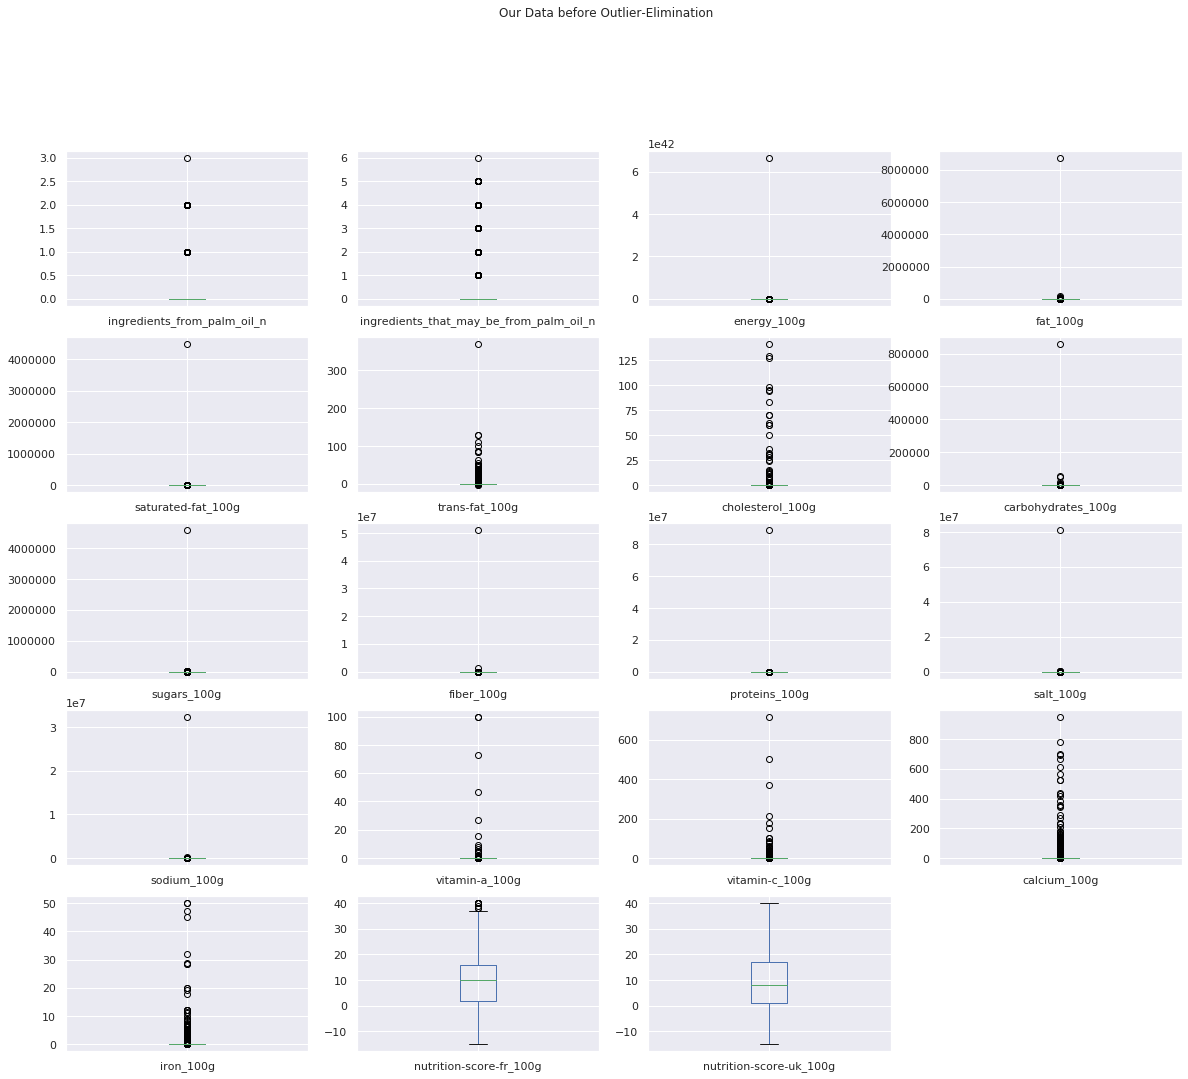

In [124]:

off.select_dtypes(include=float).plot(kind='box', subplots=True, title='Our Data before Outlier-Elimination', figsize=(20,20), layout=(6,4)) 
plt.show()

We can see that almost all the features contains some outliers. We need to deal with those before moving on. We will start by remove values that are not possible: a negative amount of energy or negative amount of nutrient in a product.

In [125]:
#we want to remove any impossible values, for example for any value that is supposed to be between 0g and 100g. We decide to keep the nan,
# because we might need these rows later.
off = off[ ((off['trans-fat_100g'] >= 0) & (off['trans-fat_100g'] <= 100) )| (off['trans-fat_100g'].isnull())]
off = off[ ((off['sugars_100g'] >= 0) & (off['sugars_100g'] <= 100) )| (off['sugars_100g'].isnull()) ]
off = off[ ((off['fiber_100g'] >= 0) & (off['fiber_100g'] <= 100) )| (off['fiber_100g'].isnull())]
off = off[ ((off['proteins_100g'] >= 0) & (off['proteins_100g'] <= 100) )| (off['proteins_100g'].isnull())]
off = off[ ((off['vitamin-a_100g'] >= 0) & (off['vitamin-a_100g'] <= 100) )| (off['vitamin-a_100g'].isnull())]
off = off[ ((off['vitamin-c_100g'] >= 0 ) & (off['vitamin-c_100g'] <= 100))| (off['vitamin-c_100g'].isnull())]
off = off[ ((off['iron_100g'] >= 0) & (off['iron_100g'] <= 100) )| (off['iron_100g'].isnull())]
off = off[ ((off['energy_100g'] >= 0) & (off['energy_100g'] <= 1500))| (off['energy_100g'].isnull())]
off = off[ ((off['fat_100g'] >= 0) & (off['fat_100g'] <= 100) )| (off['fat_100g'].isnull())]
off = off[ ((off['saturated-fat_100g'] >= 0) & (off['saturated-fat_100g'] <= 100) )| (off['saturated-fat_100g'].isnull())]
off = off[ ((off['cholesterol_100g'] >= 0) & (off['cholesterol_100g'] <= 100) )| (off['cholesterol_100g'].isnull())]
off = off[ ((off['carbohydrates_100g'] >= 0) & (off['carbohydrates_100g'] <= 100) )| (off['carbohydrates_100g'].isnull())]
off = off[ ((off['salt_100g'] >= 0) & (off['salt_100g'] <= 100) )| (off['salt_100g'].isnull())]
off = off[ ((off['sodium_100g'] >= 0) & (off['sodium_100g'] <= 100) )| (off['sodium_100g'].isnull())]
off = off[ ((off['calcium_100g'] >= 0) & (off['calcium_100g'] <= 100) )| (off['calcium_100g'].isnull())]
off.describe()

,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,304039.000000,304039.000000,526114.000000,522866.000000,497521.000000,86724.000000,87478.000000,523093.000000,513161.000000,191195.000000,524180.000000,510198.000000,510164.000000,85299.000000,89325.000000,91048.000000,86812.000000,189298.000000,189298.000000
mean,0.012331,0.064390,677.827200,6.275559,2.563070,0.039342,0.023689,19.939602,9.887314,2.246920,7.055162,1.601094,0.636025,0.004066,0.030340,0.106888,0.004330,5.968299,5.242300
std,0.111543,0.301089,466.007172,8.476014,4.338262,0.901642,0.478778,23.693386,16.640527,4.965987,8.495211,6.373444,2.542601,0.550155,0.893829,1.227950,0.270068,7.313231,7.536166
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.000000,247.000000,0.100000,0.000000,0.000000,0.000000,2.800000,0.600000,0.000000,0.600000,0.045720,0.016000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,619.000000,2.400000,0.640000,0.000000,0.000000,10.300000,3.000000,1.000000,3.700000,0.508000,0.200000,0.000021,0.000000,0.033000,0.000600,4.000000,3.000000
75%,0.000000,0.000000,1079.000000,9.800000,3.000000,0.000000,0.026000,27.900000,10.940000,2.500000,11.000000,1.390000,0.548000,0.000125,0.006700,0.106000,0.001480,12.000000,12.000000
max,3.000000,5.000000,1500.000000,100.000000,100.000000,100.000000,70.588000,100.000000,100.000000,100.000000,100.000000,100.000000,40.000000,100.000000,100.000000,100.000000,50.000000,40.000000,38.000000


In [126]:
# here we remove the outliers, we use the calculation of the 99th quantile . any value being greater than the 99th quantile is rejected,
# we do not use the negative 99th quantile as the previous step already remove the negative values.
# for the same reason we keep the outliers
off = off[ (np.abs(off['energy_100g']-off['energy_100g'].mean())<=(3*off['energy_100g'].std())) | off['energy_100g'].isnull()]
off = off[ (np.abs(off['fat_100g']-off['fat_100g'].mean())<=(3*off['fat_100g'].std())) | off['fat_100g'].isnull()]
off = off[ (np.abs(off['saturated-fat_100g']-off['saturated-fat_100g'].mean())<=(3*off['saturated-fat_100g'].std())) | off['saturated-fat_100g'].isnull()]
off = off[ (np.abs(off['trans-fat_100g']-off['trans-fat_100g'].mean())<=(3*off['trans-fat_100g'].std())) | off['trans-fat_100g'].isnull()]
off = off[ (np.abs(off['cholesterol_100g']-off['cholesterol_100g'].mean())<=(3*off['cholesterol_100g'].std())) | off['cholesterol_100g'].isnull()]
off = off[ (np.abs(off['carbohydrates_100g']-off['carbohydrates_100g'].mean())<=(3*off['carbohydrates_100g'].std())) | off['carbohydrates_100g'].isnull()]
off = off[ (np.abs(off['sugars_100g']-off['sugars_100g'].mean())<=(3*off['sugars_100g'].std())) | off['sugars_100g'].isnull()]
off = off[ (np.abs(off['fiber_100g']-off['fiber_100g'].mean())<=(3*off['fiber_100g'].std())) | off['fiber_100g'].isnull()]
off = off[ (np.abs(off['proteins_100g']-off['proteins_100g'].mean())<=(3*off['proteins_100g'].std())) | off['proteins_100g'].isnull()]
off = off[ (np.abs(off['salt_100g']-off['salt_100g'].mean())<=(3*off['salt_100g'].std())) | off['salt_100g'].isnull()]
off = off[ (np.abs(off['sodium_100g']-off['sodium_100g'].mean())<=(3*off['sodium_100g'].std())) | off['sodium_100g'].isnull()]
off = off[ (np.abs(off['vitamin-a_100g']-off['vitamin-a_100g'].mean())<=(3*off['vitamin-a_100g'].std())) | off['vitamin-a_100g'].isnull()]
off = off[ (np.abs(off['vitamin-c_100g']-off['vitamin-c_100g'].mean())<=(3*off['vitamin-c_100g'].std())) | off['vitamin-c_100g'].isnull()]
off = off[ (np.abs(off['calcium_100g']-off['calcium_100g'].mean())<=(3*off['calcium_100g'].std())) | off['calcium_100g'].isnull()]
off = off[ (np.abs(off['iron_100g']-off['iron_100g'].mean())<=(3*off['iron_100g'].std())) | off['iron_100g'].isnull()]
off.describe()


,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,271266.000000,271266.000000,465522.000000,462384.000000,441866.000000,77204.000000,78026.000000,462672.000000,454726.000000,171357.000000,463661.000000,450928.000000,450896.000000,76212.000000,80109.000000,81512.000000,77646.000000,171196.000000,171196.000000
mean,0.012379,0.067782,625.960785,5.597749,2.048063,0.014018,0.017831,18.000079,7.845246,1.777741,6.554005,0.837659,0.332063,0.000187,0.009385,0.071200,0.001186,5.278494,4.353782
std,0.111830,0.309965,443.023716,7.059828,3.024534,0.135652,0.036535,21.019049,12.022137,2.439687,7.210754,1.080910,0.429203,0.005909,0.046097,0.126016,0.003488,7.065107,7.013353
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.000000,226.000000,0.200000,0.000000,0.000000,0.000000,3.000000,0.600000,0.000000,0.700000,0.043180,0.015240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,548.000000,2.400000,0.600000,0.000000,0.000000,10.000000,3.000000,1.000000,3.600000,0.487680,0.184000,0.000026,0.000000,0.032000,0.000610,4.000000,2.000000
75%,0.000000,0.000000,992.000000,9.000000,2.700000,0.000000,0.025000,24.670000,10.000000,2.400000,10.300000,1.250000,0.493776,0.000120,0.007100,0.100000,0.001410,11.000000,10.000000
max,3.000000,5.000000,1500.000000,31.700000,14.630000,2.700000,1.081000,92.110000,59.650000,17.000000,32.100000,19.800000,2.688000,1.600000,2.400000,3.200000,0.580000,38.000000,38.000000


##Question for TAs
At this point, we hit a critical decision with our group. Do we:   
a) Filter out the rows that contain NaNs in the columns above, and end up with a dataframe of ~100'000 products, but with rows full of data, and conduct all our analysis on it? Or  
b) keep the rows with the NaNs, so we keep our dataframe with ~600'000 products, but alot of missing values, and for each question we treat, we create a new dataframe with only the relevant columns and remove rows with NaNs then?   
With the later method, we  would have more data to analyze for each individual question, but we would be working on different subsamples of the big dataframe at each step, and are worried that would disturb the uniformity of our project. Could we get you're feedback on which method you think is better?

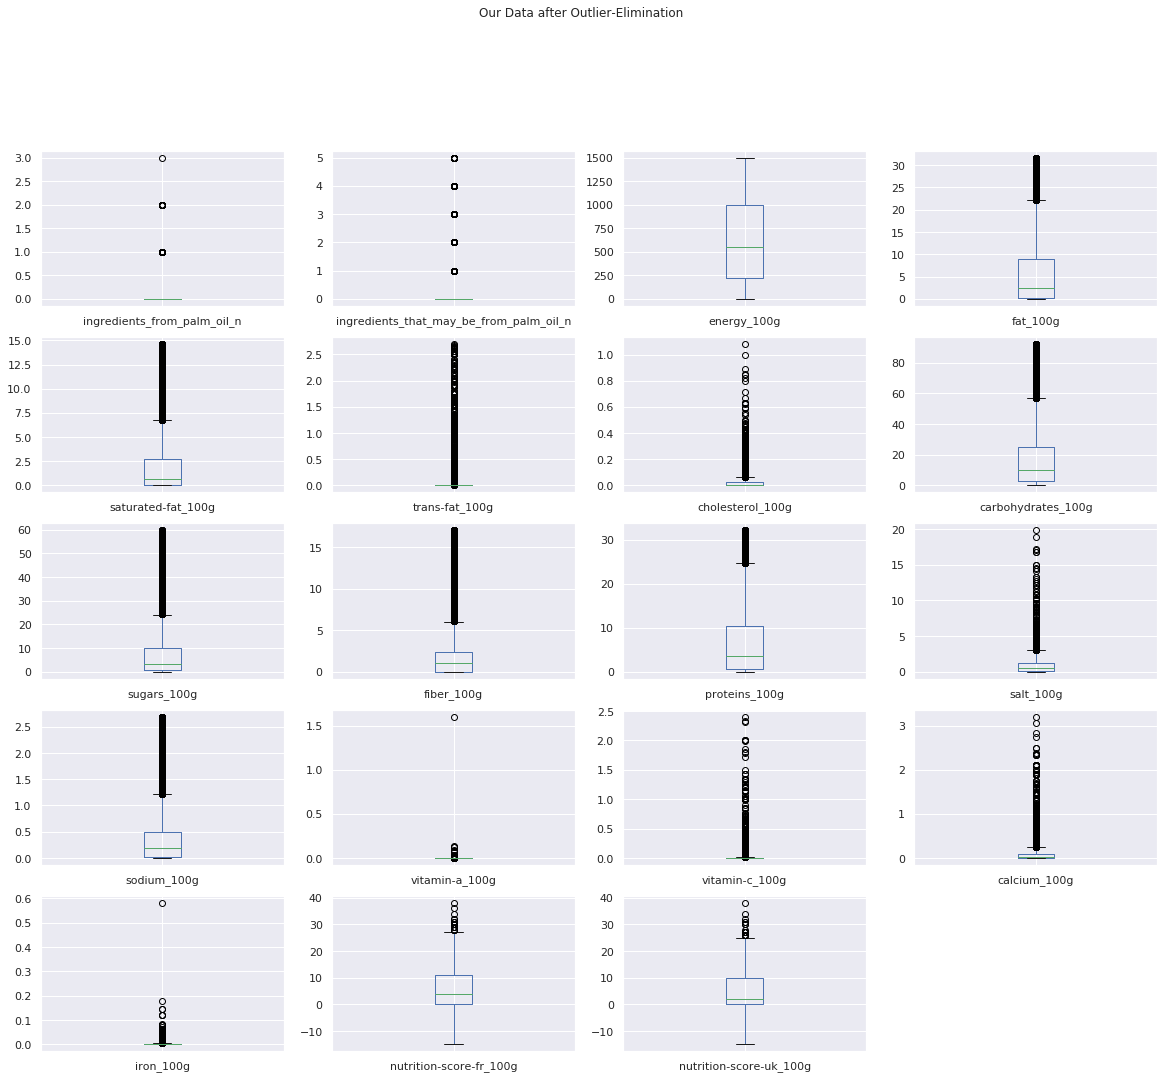

In [127]:
off.select_dtypes(include=float).plot(kind='box', subplots=True, title='Our Data after Outlier-Elimination', figsize=(20,20), layout=(6,4)) 
plt.show()

Here are the new boxplots. We cans still see outliers on the plots but, there is no data that is impossible. All the numbers that should be under 100g is under 100g etc. thus our data is plausible. In adition if we take a look at the stats shown previously, the mean, max and min are completely fine.

In [128]:
print(len(off))

619337


If we prrint the lenght of our current data set we have a

## Cleaning countries_en

In [129]:
off['countries_en'].dropna().unique().shape[0]

1552

We can clearly see that the data is not clean. Finding 1552 unique countries is impossible. 



In [130]:
off['countries_en'].unique()

array(['France', 'Ireland', nan, ...,
       'Australia,Belgium,France,United Kingdom,United States',
       'Australia,Belgium,France,Japan,New Zealand,United Kingdom,United States',
       'Australia,Belgium,France,Japan,New Zealand,United Kingdom'],
      dtype=object)

After taking a closer look at the data we can see that some countries are 'nan' and other are list of countries, thus we are gonna explode the data.

In [0]:
off_countries_exploded = off

In [0]:
off_countries_exploded['countries_en'] = off_countries_exploded['countries_en'].apply(lambda x: str(x).split(','))

In [133]:
off_countries_exploded = off_countries_exploded.explode('countries_en')
off_countries_exploded['countries_en'].unique()

array(['France', 'Ireland', 'nan', 'Belgium', 'United States',
       'United Kingdom', 'Canada', 'Switzerland', 'Peru', 'Spain',
       'Slovenia', 'Germany', 'Netherlands', 'Kuwait', 'Italy',
       'Australia', 'Portugal', 'Israel', 'Mexico', 'Guadeloupe', 'Chile',
       'Greece', 'Russia', 'India', 'Luxembourg', 'Réunion',
       'Dominican Republic', 'Singapore', 'Austria',
       'United Arab Emirates', 'Sweden', 'Gabon', 'Pakistan',
       'French Polynesia', 'Egypt', 'Palestinian territories', 'Taiwan',
       'Morocco', 'Brazil', 'En', 'Guatemala', 'Saudi Arabia', 'Iraq',
       'Romania', 'Panama', 'Colombia', 'Moldova', 'Czech Republic',
       'New Caledonia', 'Finland', 'Niger', 'Vietnam', 'Qatar',
       'New Zealand', 'Thailand', 'China', 'Saint Lucia', 'Puerto Rico',
       'Lebanon', 'Costa Rica', 'Malaysia', 'Trinidad and Tobago',
       'Jordan', 'Honduras', 'Tunisia', 'Jamaica', 'Hong Kong',
       'Mauritius', 'Saint Martin', 'Republic of Macedonia', 'Rwanda',
   

We can see that many countries have still a weird syntax or do not exist. We download a list of all countries in the world and join it.

In [134]:
off_countries_exploded['countries_en'].value_counts().tail(50)

Cayman Islands                         2
Isle of Man                            2
fr:quebec-canada                       2
fr:toronto                             1
ar:المانيا                             1
Timor-Leste                            1
French                                 1
Sint Maarten                           1
Liberia                                1
Åland Islands                          1
es:catalunya                           1
es:mundial                             1
Equatorial Guinea                      1
de:en                                  1
pt:chernobyl                           1
fr:szwajcaria                          1
Comoros                                1
Caribbean Netherlands                  1
D-e-1-d91-j-de                         1
fr:reunion-et-st-paul                  1
England                                1
Frankriika                             1
fr:niemcy                              1
es:varios                              1
Ruoŧŧa          

We can see that most of the countries that have special/wrong names are used just a few times in the data set

In [0]:
# in order to select only the countries that are existing countries a that are well written, we load from the web a list of all
#countries in the world. The next step will be to keep only the countries that are in the list.
f = open('/content/drive/My Drive/EPFL/ma1/ADA/Ada Project/country-keyword-list.txt', 'r',encoding="utf16")
list_of_countries  = [line.strip() for line in f]

In [0]:
off_countries_exploded = off_countries_exploded[off_countries_exploded['countries_en'].apply(lambda x: x in list_of_countries)]

In [138]:
off_countries_exploded['countries_en'].unique().shape[0]

157

We now have 157 unique countries left and more than 650,000 lines in our data set.

In [0]:
off_countries_exploded.to_csv('/content/drive/My Drive/EPFL/ma1/ADA/Ada Project/results_ms_2.csv')

# Exploring the data

In [142]:
!pip install geopandas
import geopandas as gpd

In [205]:
#Read shapefile using Geopandas
gdf = gpd.read_file('/content/drive/My Drive/EPFL/ma1/ADA/Ada Project/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')[['ADMIN', 'ADM0_A3', 'geometry']]
#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head()

,country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [206]:
#Renaming United States of America
gdf.loc[4, 'country'] = 'United States'
#Drop row corresponding to 'Antarctica'
print(gdf[gdf['country'] == 'Antarctica'])
gdf = gdf.drop(gdf.index[159])

        country country_code                                           geometry
159  Antarctica          ATA  MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...


In [207]:
#making dataframe of country count percentges
country_counts_std = (((off_countries_exploded['countries_en'].value_counts())/len(off_countries_exploded))*100).to_frame('counts')
country_counts_std['country'] = country_counts_std.index
country_counts_std

,counts,country
France,78.907125,France
United States,21.092875,United States


In [208]:
#merged = gdf.merge(country_counts_std, left_on = 'country', right_on = 'country')
merged = gdf.merge(country_counts_std, on = 'country', how = 'left')
#Replace NaN values to string 'No data'.
merged.fillna({'counts' : 'No data'}, inplace = True)
merged

,country,country_code,geometry,counts
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",No data
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",No data
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",No data
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",No data
4,United States,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",21.0929
...,...,...,...,...
171,Republic of Serbia,SRB,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",No data
172,Montenegro,MNE,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",No data
173,Kosovo,KOS,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",No data
174,Trinidad and Tobago,TTO,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",No data


In [0]:
import json
#Read data to json.
merged_json = json.loads(merged.to_json())
#Convert to String like object.
json_data = json.dumps(merged_json)

In [210]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)
#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 40, nan_color = '#d9d9d9')
#Define custom tick labels for color bar.
tick_labels = {'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%', '30':'30%','35':'35%', '40': '>40%'}
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)
#Create figure object.
p = figure(title = 'Percentage of products sold across countries', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.xaxis.visible = False
p.yaxis.visible = False
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'counts', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Display figure inline in Jupyter Notebook.
output_notebook()
#Display figure.
show(p)

We can see here the hegemony of France in the dataset, as more than 50% of the data comes from France. Thus we will have to consider this bias in our future analysis. However we still have relevant country wise data for countries such as the USA or even Spain and Switzerland. They still are representative of their own population, considering the size of the dataset.


##Question 1: To what extent does this database represent the global food consumption
The Amount of data coming from France and the USA represent almost 3/4 of the  whole dataset. Therefore we cannot say that the dataset gives a good representation of food consunmption in the world. In addition some countries are not even represented.

Threfore, we decided to focus our questions on the two most represented countries: France and the USA. Each question that we planned on doing on a world scale will be done between these two countries.

In [211]:
off_countries_exploded['packaging'].dropna().unique()

array(['bocal,plastique', 'plastique', 'carton,plastique', ...,
       '8×4biscuits', 'Boîte,Carton,Refermable', 'cube plastique'],
      dtype=object)

In [0]:
off_packaging_cleaned = off_countries_exploded

In [0]:
indexNames = off_packaging_cleaned[ (off_packaging_cleaned['countries_en'] != 'United States') & (off_packaging_cleaned['countries_en'] != 'France') ].index
off_packaging_cleaned.drop(indexNames , inplace=True)

In [0]:
off_packaging_cleaned = off_packaging_cleaned[pd.notnull(off_packaging_cleaned['packaging'])]

In [0]:
off_packaging_cleaned = off_packaging_cleaned[pd.notnull(off_packaging_cleaned['countries_en'])]

In [216]:
off_packaging_cleaned['packaging'].value_counts().head()

Bouteille,Verre     2470
Conserve            1692
Plastique           1426
Bocal,Verre         1295
sachet,plastique    1279
Name: packaging, dtype: int64

In [0]:
off_packaging_cleaned_exploded = off_packaging_cleaned

In [0]:
off_packaging_cleaned_exploded['packaging'] = off_packaging_cleaned['packaging'].apply(lambda x: str(x).split(','))

In [0]:
off_packagin_cleaned_exploded = off_packaging_cleaned.explode('packaging')

In [0]:
off_packagin_cleaned_exploded['packaging'] = off_packagin_cleaned_exploded['packaging'].apply(lambda x: str(x).lower())

In [221]:
off_packagin_cleaned_exploded['packaging'].value_counts().head()

plastique    32260
carton       15687
frais        12196
verre        11141
bouteille     9240
Name: packaging, dtype: int64

In [222]:
off_packagin_cleaned_exploded['countries_en'].value_counts().head()

France           195920
United States      2910
Name: countries_en, dtype: int64

In [0]:
plastic_list = ['plastic','plastic ','plastique','plastique ']

In [0]:
off_packagin_cleaned_plastic = off_packagin_cleaned_exploded[off_packagin_cleaned_exploded['packaging'].apply(lambda x: any(plast in x for plast in plastic_list))]

In [225]:
off_packagin_cleaned_plastic['packaging'].value_counts().head()

plastique              32260
sachet plastique        1529
film plastique           934
plastic                  853
bouteille plastique      601
Name: packaging, dtype: int64

In [226]:
off_packagin_cleaned_plastic.groupby('countries_en').size()

countries_en
France           41382
United States      651
dtype: int64

In [0]:
off_origins = off_countries_exploded

In [0]:
indexNames = off_origins[ (off_origins['countries_en'] != 'United States') & (off_origins['countries_en'] != 'France') ].index
off_origins.drop(indexNames , inplace=True)

In [0]:
off_origins = off_origins[pd.notnull(off_origins['origins'])]

In [0]:
origins_exploded = off_origins

In [231]:
origins_exploded['origins'] = origins_exploded['origins'].apply(lambda x: str(x).split(','))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
origins_exploded = origins_exploded.explode('origins')

In [0]:
origins_exploded['origins'] = origins_exploded['origins'].apply(lambda x: str(x).lower())

In [234]:
origins_exploded['origins'].value_counts().head(5)

france              14042
union européenne     2186
espagne              1035
italie                952
norvège               346
Name: origins, dtype: int64

In [0]:
df_US = origins_exploded.groupby('countries_en').get_group('United States')

In [0]:
df_FR = origins_exploded.groupby('countries_en').get_group('France')

In [237]:
df_US['origins'].value_counts().head()

usa               52
united states     42
france            23
california        22
estados unidos    20
Name: origins, dtype: int64

#Correlation matrix 
If we take a closer look at the correlation matrix, we can deduce and discover interesting information. For example we can support  the already existing formula for the nutrition score. The formula for this score is available online. It takes into account many different factor and is ranked betweeen -15 for the best products and 40 for the worst ones. Here we have a clearer view of which nutrient impact the most the nutri score. For example the energy, the fat and transfat contained in a product will drasticly increase the nutriscore which seems logical. But the we can se also more interestingly that the aount fiber has a negative correlation with the nutrition score, the more fiber there is the lower is the nutrition score, thus a better product.

Surpinsingly also the sugar and fat are negativly correlated the fatter the product the less ugar ther is in it. Also we can see that protein and sugar are following the same trend as the previous nutrient, if the product is rich in protein it will be low in sugar.

Looking at this matrix we can fetch many information that will explain some of our later results.

In [0]:
off_nutri_score = off_countries_exploded

In [0]:
off_nutri_score = off_nutri_score[pd.notnull(off_nutri_score['nutrition-score-fr_100g'])]

In [0]:
off_nutri_score = off_nutri_score[((off_nutri_score['countries_en'] == 'United States') | (off_nutri_score['countries_en'] == 'France'))]

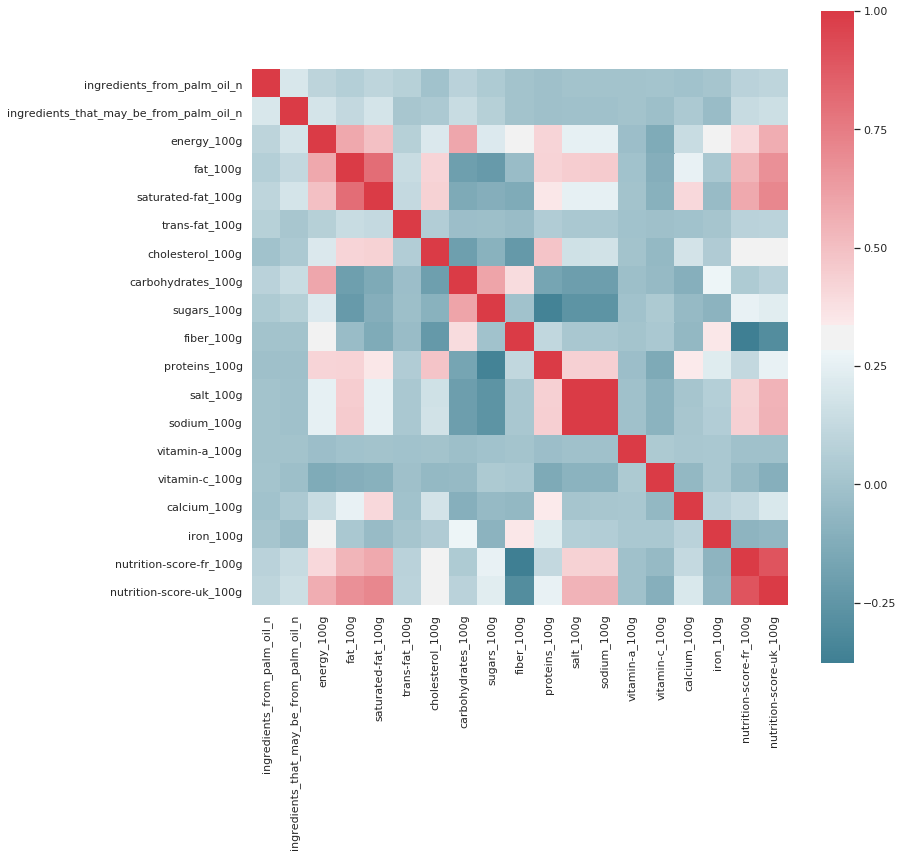

In [149]:
corr = off_nutri_score.corr(method = "pearson")

f, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)

#Nutrion score and nutrition grade between the 2 countries
Here we can see a clear difference between the United States and France. If we take a look at the graph about the nutrition grade, we can see that the US has a higher percentage of product with the highest grade. Regarding the grades from 'B' to 'D' we do not notice any big differences, even if France has a slightly higher share of 'B' graded product. The main information comes for the product falling in the 'E' grade.
Indeed, French product are almost twice as many compared to the US ones. This is directly linked to our previous results. If we take a look at the graph focusing on fat quantity in the products, we see that french products tends to be fatter than american ones. Then, if we remember the correlation matrix we saw that fat is higly correlated with the nutrion score , thus grade.

If we take a look at the distribution of the nutrition score we can observe the same treend as the nutrion grade.
Though, we can notice a bimodal distribution for both of the countries. We observe peak around 5 for both of the countries, then another one a little after 10. We notice then that the products present in the data-set are separated in two different clusters. This can be explained that very few products fall in this categorie. Products grades tend to be polarized towards the extremes.

To further explain the difference between the US and France in the nutrition grade we could look again at the preivous graphs. The correlation matrix shows that fat have a much higher impact on the grade than the sugar. We also see that the US have more sugar than france but less fat. 
The reason for such a difference can be explained by taking a look at policies that were in place in the second half of the XXth century in the US.
We focused on the article published by Cristin E. Kearns, Laura A. Schmidt and  Stanton A. Glantz from the Philip R. Lee Institute for Health Policy Studies, San Francisco, California in 2016 entitled : "Sugar Industry and Coronary Heart Disease Research". In this article we see that  a trade group called the Sugar Research Foundation, known today as the Sugar Association, paid three Harvard scientists the equivalent of about $50,000 in today’s dollars to publish a 1967 review of research on sugar, fat and heart disease. The studies used in the review were handpicked by the sugar group, and the article, which was published in the prestigious New England Journal of Medicine, minimized the link between sugar and heart health and cast aspersions on the role of saturated fat. “They were able to derail the discussion about sugar for decades,” said Stanton Glantz, a professor of medicine at U.C.S.F. and an author of the JAMA Internal Medicine paper.

Thus america, for the past five decades started to substitute the fat by sugar in their products. Creating a very large amount of "hidden sugar".

On the other hand, France has always been a country with a fat diet. Cheese is a very important feature of the french diet for example. If we use the numbers given by the report from the "High Council of Public Health" using the QUALI database in 2015, cheeses cannot be graded better than "C", moreover we see that more than 90% of cheeses are "D" or "E".  With the same reasoning if we look at delicatessen in the report, it shows that almost 70% of these products are in the "D" or "E" grade. France tend to have more tradiional food that will fall in the end of the ranking. This explains the high share of "E" and "D" product in France

In [0]:
off_nutri_score_FR = off_countries_exploded
off_nutri_score_US = off_countries_exploded

In [0]:
off_nutri_score_US = off_nutri_score_US[pd.notnull(off_nutri_score_US['nutrition-score-fr_100g'])]
off_nutri_score_FR = off_nutri_score_FR[pd.notnull(off_nutri_score_FR['nutrition-score-fr_100g'])]

In [0]:
off_nutri_score_US = off_nutri_score_US[off_nutri_score_US['countries_en'] == 'United States']
off_nutri_score_FR = off_nutri_score_FR[off_nutri_score_FR['countries_en'] == 'France']

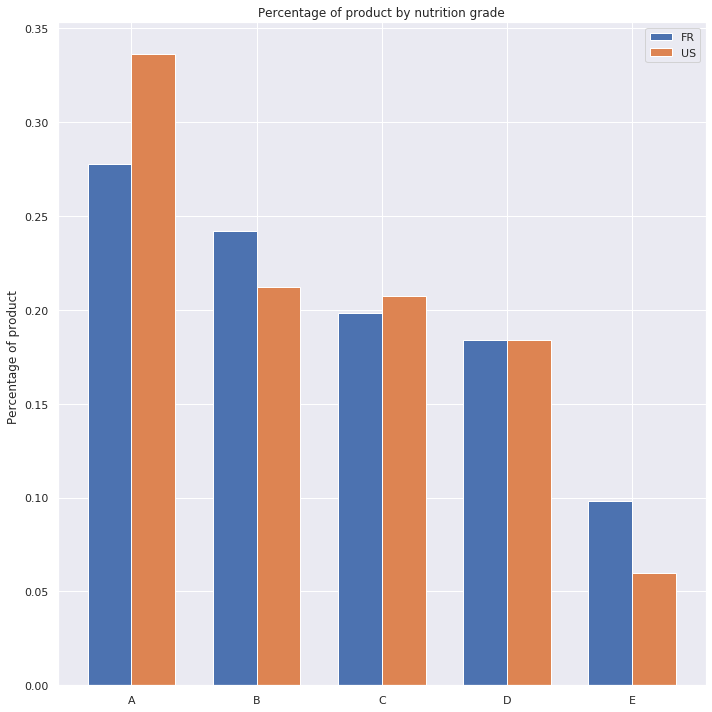

In [153]:

labels = ['A', 'B', 'C', 'D', 'E']
FR = off_nutri_score_FR.nutrition_grade_fr.value_counts()/len(off_nutri_score_FR.nutrition_grade_fr)
US = off_nutri_score_US.nutrition_grade_fr.value_counts()/len(off_nutri_score_US.nutrition_grade_fr)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize = (10,10))
rects1 = ax.bar(x - width/2, FR, width, label='FR')
rects2 = ax.bar(x + width/2, US, width, label='US')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of product ')
ax.set_title('Percentage of product by nutrition grade')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()
plt.show()


<Figure size 1440x720 with 0 Axes>

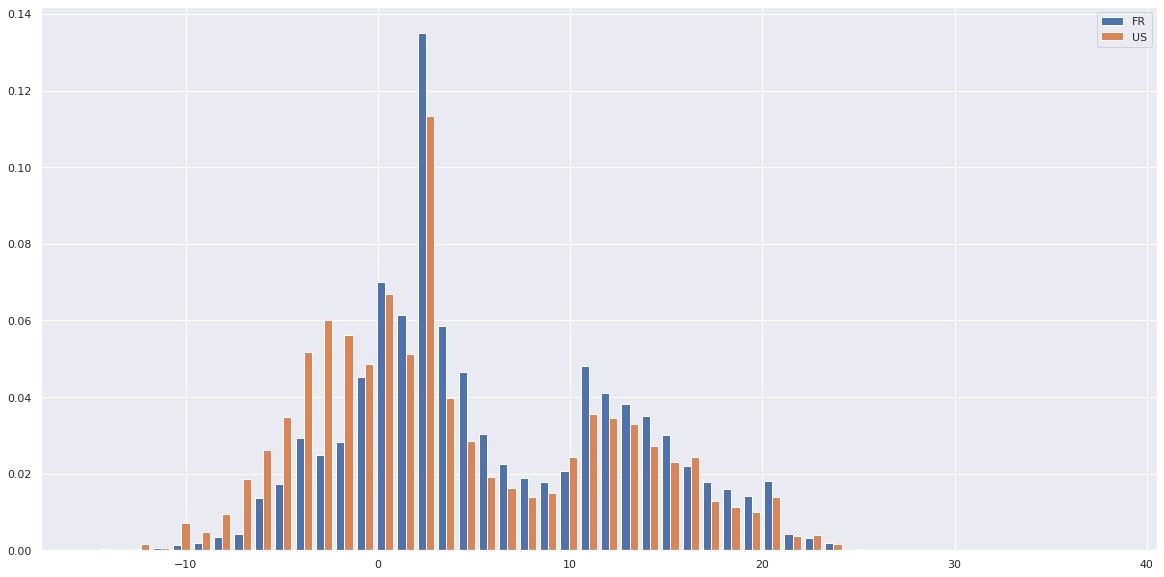

In [154]:

fig= plt.figure(figsize=(20,10))
x = off_nutri_score_FR['nutrition-score-fr_100g']
y = off_nutri_score_US['nutrition-score-fr_100g']

bins = 50
fig= plt.figure(figsize=(20,10))

plt.hist([x, y], bins, label=['FR', 'US'],density=True)
plt.legend(loc='upper right')
plt.show()

#Food characterisitcs USA vs France

In [0]:
off_countries_exploded = off_countries_exploded[(off_countries_exploded['countries_en']=='United States')|
                                        (off_countries_exploded['countries_en']=='France')]

In [0]:
countries_grouped = off_countries_exploded.groupby('countries_en')

In [157]:
countries_grouped.describe()

ingredients_from_palm_oil_n                      ... nutrition-score-uk_100g            
                                    count      mean       std  ...                     50%   75%   max
countries_en                                                   ...                                    
France                           132509.0  0.020006  0.141629  ...                     3.0  11.0  38.0
United States                     97015.0  0.000031  0.005561  ...                     2.0   9.0  25.0

[2 rows x 152 columns]

In [158]:
country_fat = countries_grouped['fat_100g'].describe().sort_values(by='mean',ascending=False).head(10)
country_fat

,count,mean,std,min,25%,50%,75%,max
countries_en,,,,,,,,
France,282024.0,5.986296,7.214398,0.0,0.5,2.90,9.70,31.7
United States,97541.0,4.599275,6.735426,0.0,0.0,1.16,7.14,31.7


In [159]:
country_sugar = countries_grouped['sugars_100g'].describe().sort_values(by='mean',ascending=False)
country_sugar

,count,mean,std,min,25%,50%,75%,max
countries_en,,,,,,,,
United States,91807.0,9.387092,12.305807,0.0,1.18,4.38,12.39,59.65
France,282714.0,7.655653,12.261327,0.0,0.60,2.50,9.70,59.60


In [160]:
country_salt = countries_grouped['salt_100g'].describe().sort_values(by='mean',ascending=False)
country_salt

,count,mean,std,min,25%,50%,75%,max
countries_en,,,,,,,,
United States,96590.0,0.861611,1.108402,0.0,0.0381,0.47752,1.27,14.4
France,274241.0,0.845881,1.084646,0.0,0.0400,0.50000,1.27,18.9


In [161]:
country_healthy_fr = countries_grouped['nutrition-score-fr_100g'].describe().sort_values(by='mean',ascending=True)
country_healthy_fr

,count,mean,std,min,25%,50%,75%,max
countries_en,,,,,,,,
United States,13528.0,3.813868,7.587606,-14.0,-2.0,2.0,10.0,25.0
France,123305.0,5.754909,7.066895,-15.0,0.0,4.0,12.0,38.0


In [162]:
country_healthy_uk = countries_grouped['nutrition-score-uk_100g'].describe().sort_values(by='mean',ascending=True)
country_healthy_uk

,count,mean,std,min,25%,50%,75%,max
countries_en,,,,,,,,
United States,13528.0,3.361177,7.520511,-14.0,-2.0,2.0,9.0,25.0
France,123305.0,4.715056,7.046653,-15.0,0.0,3.0,11.0,38.0


In [163]:
country_palm = countries_grouped['ingredients_that_may_be_from_palm_oil_n'].describe().sort_values(by='mean',ascending=True)
country_palm

,count,mean,std,min,25%,50%,75%,max
countries_en,,,,,,,,
United States,97015.0,0.031696,0.178744,0.0,0.0,0.0,0.0,3.0
France,132509.0,0.097767,0.381470,0.0,0.0,0.0,0.0,5.0


In [164]:
country_trans_fat = countries_grouped['trans-fat_100g'].describe().sort_values(by='mean',ascending=False).head(10)
country_trans_fat

,count,mean,std,min,25%,50%,75%,max
countries_en,,,,,,,,
France,790.0,0.023857,0.109669,0.0,0.0,0.0,0.0,1.78
United States,76504.0,0.013393,0.134436,0.0,0.0,0.0,0.0,2.70


In [165]:
country_saturated_fat = countries_grouped['saturated-fat_100g'].describe().sort_values(by='mean',ascending=False).head(10)
country_saturated_fat

,count,mean,std,min,25%,50%,75%,max
countries_en,,,,,,,,
France,282441.0,2.116374,3.026962,0.0,0.1,0.7,2.80,14.63
United States,79924.0,1.947615,3.187372,0.0,0.0,0.0,2.78,14.63


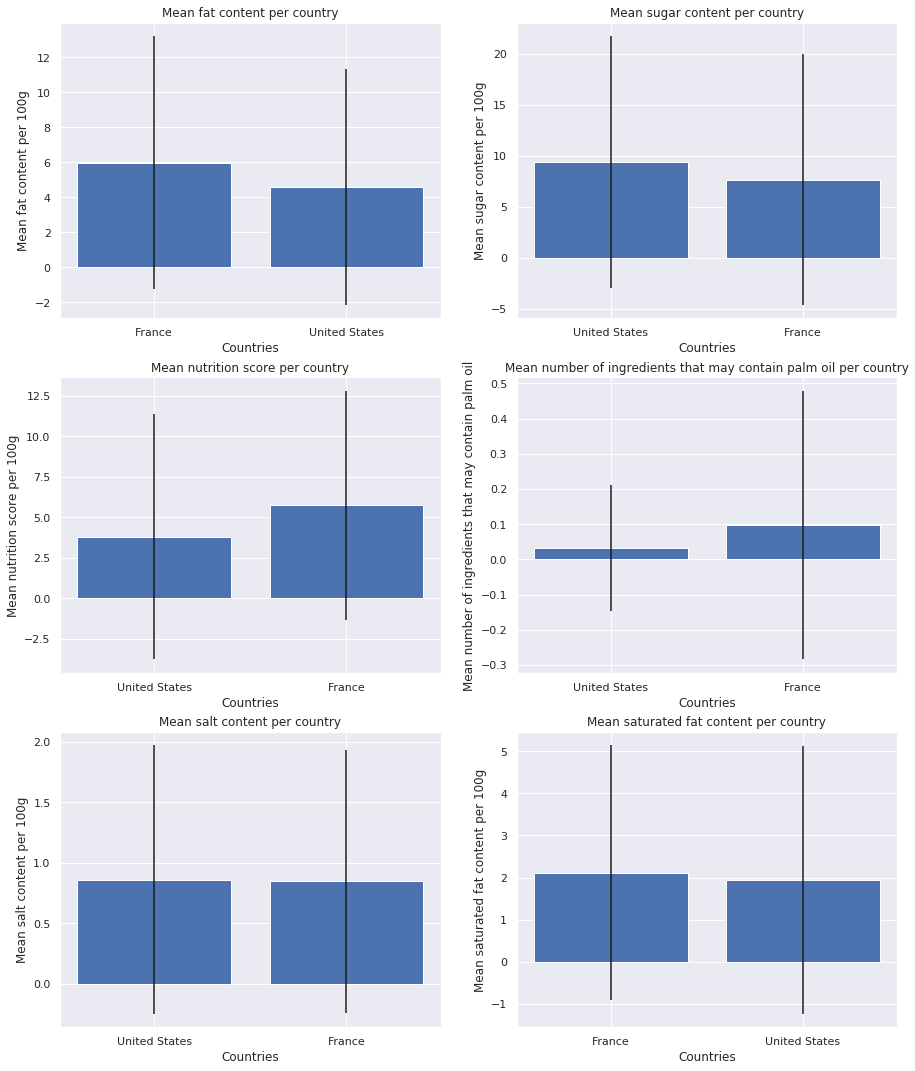

In [166]:
fig = plt.figure()
fig.set_figheight(25)
fig.set_figwidth(15)

plt.subplot(4,2,1)
index_fat = country_fat.index
mean_fat = country_fat['mean'] 
std_fat = country_fat['std']

x_pos_fat = [i for i, _ in enumerate(index_fat)]
plt.bar(x_pos_fat, mean_fat, yerr=std_fat)
plt.xlabel("Countries")
plt.ylabel("Mean fat content per 100g")
plt.title("Mean fat content per country")
plt.xticks(x_pos_fat, index_fat)


plt.subplot(4,2,2)
index_sugar = country_sugar.index
mean_sugar = country_sugar['mean'] 
std_sugar = country_sugar['std']

x_pos_sugar = [i for i, _ in enumerate(index_sugar)]
plt.bar(x_pos_sugar, mean_sugar, yerr=std_sugar)
plt.xlabel("Countries")
plt.ylabel("Mean sugar content per 100g")
plt.title("Mean sugar content per country")
plt.xticks(x_pos_sugar, index_sugar)

plt.subplot(4,2,3)
index_healthy_fr = country_healthy_fr.index
mean_healthy_fr = country_healthy_fr['mean'] 
std_healthy_fr = country_healthy_fr['std']

x_pos_healthy_fr = [i for i, _ in enumerate(index_healthy_fr)]
plt.bar(x_pos_healthy_fr, mean_healthy_fr, yerr=std_healthy_fr)
plt.xlabel("Countries")
plt.ylabel("Mean nutrition score per 100g")
plt.title("Mean nutrition score per country")
plt.xticks(x_pos_healthy_fr, index_healthy_fr)

plt.subplot(4,2,4)
index_palm = country_palm.index
mean_palm = country_palm['mean'] 
std_palm = country_palm['std']

x_pos_palm = [i for i, _ in enumerate(index_palm)]
plt.bar(x_pos_palm, mean_palm, yerr=std_palm)
plt.xlabel("Countries")
plt.ylabel("Mean number of ingredients that may contain palm oil")
plt.title("Mean number of ingredients that may contain palm oil per country")
plt.xticks(x_pos_palm, index_palm)

#plt.subplot(4,2,5)
#index_trans_fat = country_trans_fat.index
#mean_trans_fat = country_trans_fat['mean'] 
#std_trans_fat = country_trans_fat['std']
#
#x_pos_trans_fat = [i for i, _ in enumerate(index_trans_fat)]
#plt.bar(x_pos_trans_fat, mean_trans_fat, yerr=std_trans_fat)
#plt.xlabel("Countries")
#plt.ylabel("Mean trans fat content per 100g")
#plt.title("Mean trans fat content per country")
#plt.xticks(x_pos_fat, index_fat)

plt.subplot(4,2,6)
index_saturated_fat = country_saturated_fat.index
mean_saturated_fat = country_saturated_fat['mean'] 
std_saturated_fat = country_saturated_fat['std']

x_pos_saturated_fat = [i for i, _ in enumerate(index_saturated_fat)]
plt.bar(x_pos_saturated_fat, mean_saturated_fat, yerr=std_saturated_fat)
plt.xlabel("Countries")
plt.ylabel("Mean saturated fat content per 100g")
plt.title("Mean saturated fat content per country")
plt.xticks(x_pos_fat, index_fat)

plt.subplot(4,2,5)
index_salt = country_salt.index
mean_salt = country_salt['mean'] 
std_salt = country_salt['std']

x_pos_salt = [i for i, _ in enumerate(index_salt)]
plt.bar(x_pos_salt, mean_salt, yerr=std_salt)
plt.xlabel("Countries")
plt.ylabel("Mean salt content per 100g")
plt.title("Mean salt content per country")
plt.xticks(x_pos_salt, index_salt)


plt.show()

We often stigmatize the american diet by saying that it is unhealthy compared to the rest of the world. So we decided to look into the nutrition facts of the products sold in the United States compared to France to see whether this stigma is confirmed by data. We look at the difference in mean content of nutrients commonly known as 'unhealthy' (fat, sugar, sodium, palm oil, trans fat, saturated fat) in products sold in the US opposed to France.
The results we obtained (Figure ) go back and forth between the two countries, and do not point to a particular country diet as being healthier. We can see that French products have a higher mean fat content, whereas American products contain more sugar. French products also contain more ingredients that may contain palm oil. The nutritional score is higher (worse) in French prodcuts due to the fact that this value is highly correlated with fat. No significant difference is observed in saturated fat and salt content. Trans fats turned out not to be an interesting statistic to look at because not enough French products had data for this field. Not much can be concluded from these results, we cannot say that one country is healthier than the other. Furthermore, this dataset is not very indicative of a country's diet as it does not represent consumption behaviour, but only a range of available products. Healthy and unhealthy products are found in every country, and this is not what determines the country's diet. The diet is rather determined by the consumption behaviour and habits of the country's population : Which products do they buy? How many times do they eat out on average? Do they opt for healthy meals or fast food when they do eat out?

#Study of the brands in each country


In [167]:
data_country_brand = data[['brands_tags', 'countries_en']].dropna()
data_country_brand.shape[0]

595478

##France

In [0]:
data_france_brand = data_country_brand[data_country_brand['countries_en'] == 'France']['brands_tags']

In [169]:
data_france_brand.describe()

count     264008
unique     43015
top       auchan
freq        7644
Name: brands_tags, dtype: object

In [170]:
data_france_brand = data_france_brand.value_counts()
data_france_brand = data_france_brand[data_france_brand > 2]
data_france_brand.shape[0]

10221

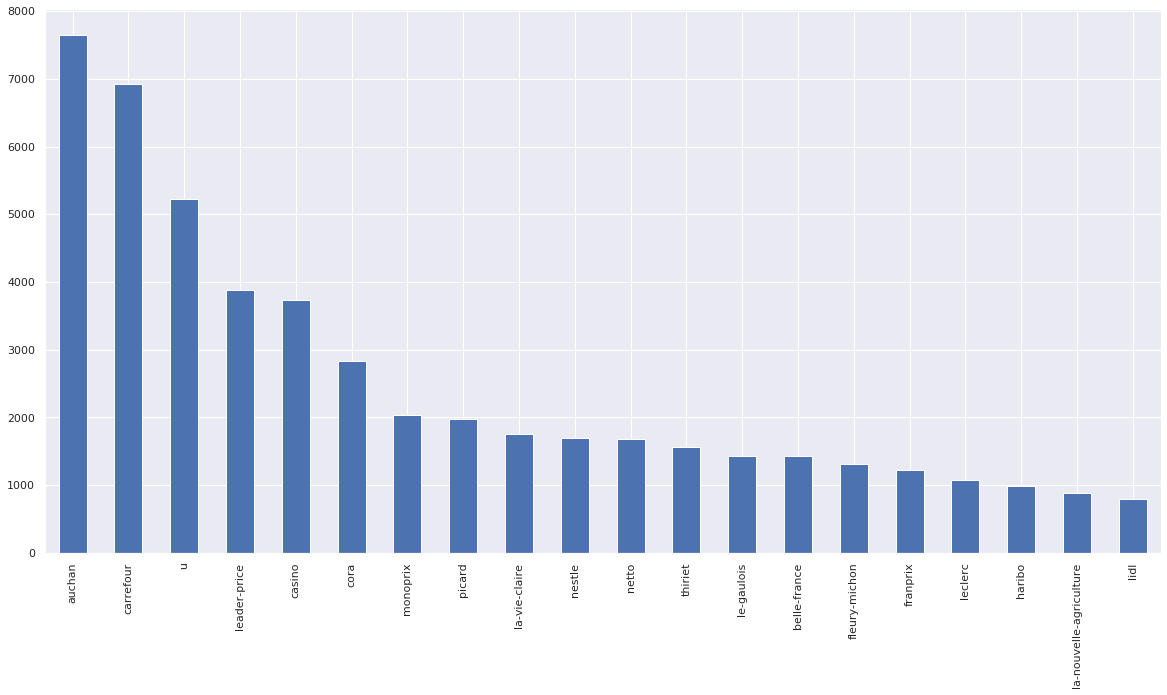

In [171]:
data_france_brand.head(20).plot(kind="bar", figsize=(20,10))

We can clearly see the hegemony of auchan and carrefour in the OFF dataset for France, followed by u, leader price and casino. We can also see that the large majority of the brands are only represented once or twice. This shows how the retailers dominate the market of food, in comparison with the simple brands like fleury-michon or even nestlé.

##USA

In [0]:
data_us_brand = data_country_brand[data_country_brand['countries_en'] == 'United States']['brands_tags']

In [173]:
data_us_brand = data_us_brand.value_counts()
data_us_brand = data_us_brand[data_us_brand > 2]
data_us_brand.shape[0]

10122

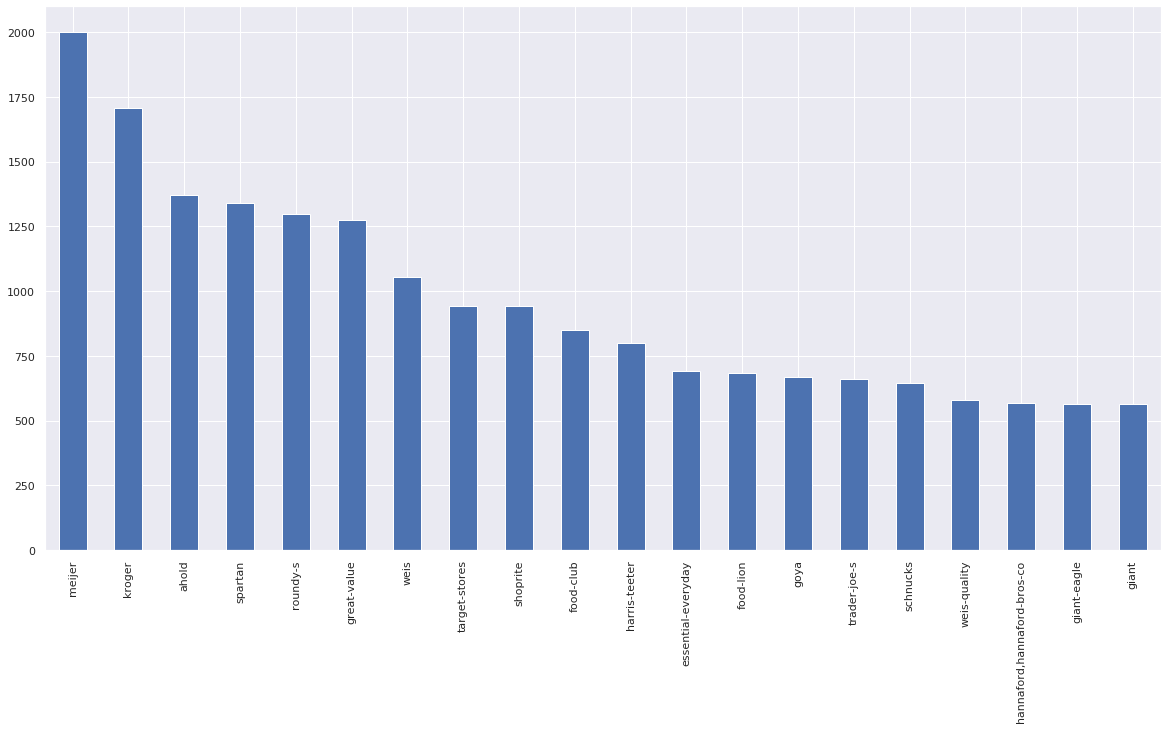

In [174]:
data_us_brand.head(20).plot(kind="bar", figsize=(20,10))

Here, we can see quite the same thing, that is to say; stores have a large share of the market in this dataset compared to productor-only brands.

#Study of the ecological footprint of the different major brands

In [175]:
data = pd.read_csv('/content/drive/My Drive/EPFL/ma1/ADA/Ada Project/results_ms_2.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [176]:
us_sample = data_us_brand.head(20).index
fr_sample = data_france_brand.head(20).index
us_sample = ['meijer', 'kroger', 'ahold', 'spartan', 'great-value', 'roundy-s',
       'weis', 'target-stores', 'harris-teeter', 'shoprite', 'goya',
       'food-lion', 'food-club', 'giant-eagle', 'trader-joe-s',
       'essential-everyday', 'schnucks', 'wegmans', 'weis-quality',
       '365-everyday-value']
sample_comp = ['auchan','365-everyday-value', 'belle-france','essential-everyday', 'bonduelle','foodlion', 'carrefour','goya', 'casino','great-value', 'cora','kroger', 'delhaize','meijer',
       'fleury-michon','schnuks','haribo','targets-stores','knorr','trader-joe']
len(sample_comp)

20

##France

In [0]:
data_major_brands_fr = data[data.brands_tags.isin(fr_sample)]

In [178]:
data_major_brands_fr.describe()

,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,25959.000000,25959.000000,35997.000000,35574.000000,35642.000000,91.000000,50.000000,35678.000000,35781.000000,17492.000000,35891.000000,35283.000000,35283.000000,123.000000,396.000000,534.000000,98.000000,23909.000000,23909.000000
mean,0.014985,0.125390,638.307453,5.864576,2.241956,0.060895,0.028689,16.686135,7.425698,1.725617,7.801823,0.787831,0.314977,0.000120,0.020664,0.128357,0.003420,4.433268,3.799908
std,0.121812,0.414547,412.482941,6.474725,2.979070,0.074503,0.090747,20.168171,11.935240,1.896206,7.474506,0.920394,0.368248,0.000130,0.019948,0.126290,0.004536,6.960520,6.928870
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.000000,297.000000,0.600000,0.100000,0.000000,0.000000,2.100000,0.700000,0.400000,1.800000,0.100000,0.040000,0.000067,0.012000,0.080750,0.000753,0.000000,-1.000000
50%,0.000000,0.000000,561.000000,3.400000,1.000000,0.000000,0.000000,10.000000,2.500000,1.300000,5.400000,0.600000,0.240000,0.000107,0.020000,0.120000,0.001200,3.000000,2.000000
75%,0.000000,0.000000,960.000000,9.200000,3.000000,0.100000,0.001225,22.000000,9.000000,2.400000,12.000000,1.200000,0.480000,0.000120,0.024000,0.122000,0.003210,10.000000,8.000000
max,2.000000,5.000000,1500.000000,31.600000,14.600000,0.300000,0.378000,92.000000,59.500000,16.600000,32.100000,6.700000,2.680000,0.000650,0.217000,1.285000,0.017000,26.000000,26.000000


In [0]:
data_major_brands_fr_cleaned = data_major_brands_fr[pd.notnull(data_major_brands_fr['packaging'])]

In [180]:
data_major_brands_fr_cleaned.describe()

,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,15714.000000,15714.000000,15678.000000,15619.000000,15563.000000,40.000000,9.000000,15607.000000,15584.000000,10486.000000,15649.000000,15444.000000,15444.000000,64.000000,295.000000,380.000000,33.000000,14491.000000,14491.000000
mean,0.014891,0.128357,623.569285,5.807444,2.204957,0.106035,0.134589,16.188016,7.030670,1.757654,7.441598,0.814712,0.325566,0.000161,0.021430,0.137816,0.005776,4.254917,3.720171
std,0.121121,0.418355,405.990435,6.401001,2.938535,0.071119,0.183679,19.330070,11.487395,1.877575,7.158186,0.952135,0.381043,0.000138,0.014527,0.135030,0.005262,7.040337,7.082421
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004180,0.000400,0.000225,-14.000000,-14.000000
25%,0.000000,0.000000,284.250000,0.500000,0.100000,0.092850,0.000000,2.500000,0.800000,0.500000,1.600000,0.100000,0.040000,0.000120,0.015000,0.120000,0.002100,-1.000000,-1.000000
50%,0.000000,0.000000,545.500000,3.400000,1.000000,0.100000,0.012000,10.000000,2.430000,1.400000,5.300000,0.640000,0.254000,0.000120,0.020000,0.120000,0.003600,3.000000,2.000000
75%,0.000000,0.000000,937.000000,9.100000,3.000000,0.162500,0.378000,21.000000,8.000000,2.400000,11.000000,1.200000,0.480000,0.000122,0.024000,0.129250,0.008000,10.000000,9.000000
max,1.000000,4.000000,1500.000000,31.400000,14.600000,0.200000,0.378000,90.900000,59.500000,16.000000,32.100000,6.700000,2.680000,0.000650,0.217000,1.285000,0.017000,24.000000,24.000000


In [181]:
data_major_brands_fr_cleaned['packaging'].value_counts().head()

Frais                       463
Conserve                    423
Bouteille,Plastique         306
Sachet,Plastique            263
sachet,plastique,surgelé    238
Name: packaging, dtype: int64

In [182]:
data_major_brands_fr_cleaned['packaging'] = data_major_brands_fr_cleaned['packaging'].apply(lambda x: str(x).lower())
data_major_brands_fr_cleaned['packaging'].value_counts().head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


conserve                    644
barquette,plastique         536
sachet,plastique            524
frais                       490
sachet,plastique,surgelé    471
Name: packaging, dtype: int64

In [183]:
data_major_brands_fr_cleaned.brands_tags.value_counts().sort_index(ascending = True)

auchan                     2286
belle-france                638
carrefour                  2668
casino                     1230
cora                        914
fleury-michon               635
franprix                    331
haribo                      338
la-nouvelle-agriculture      31
la-vie-claire               246
le-gaulois                  409
leader-price               1370
leclerc                     212
lidl                        240
monoprix                    612
nestle                      533
netto                       425
picard                     1410
thiriet                     381
u                          2658
Name: brands_tags, dtype: int64

In [184]:
data_major_brands_fr_cleaned_plastic = data_major_brands_fr_cleaned[data_major_brands_fr_cleaned['packaging'].apply(lambda x: fuzz.partial_ratio(x.lower(),"plastic")>60 or fuzz.partial_ratio(x.lower(),"kunststoff")>60 or fuzz.partial_ratio(x.lower(),"stück")>60)]
data_major_brands_fr_cleaned_plastic['packaging'].value_counts().head()

barquette,plastique         536
sachet,plastique            524
sachet,plastique,surgelé    471
bouteille,plastique         453
plastique                   428
Name: packaging, dtype: int64

We can observe that the chosen threshold for the fuzzywuzzy partial ratio gives us a good filter over plastic material. Thus we can infer an accurate approximation of the precentage of plastic in brands' packaging.

In [0]:
data_major_brands_fr_cleaned_plastic = data_major_brands_fr_cleaned_plastic.groupby('brands_tags').size()


In [0]:
data_major_brands_fr_cleaned_plastic_percentage = data_major_brands_fr_cleaned_plastic.sort_index().div(data_major_brands_fr_cleaned.brands_tags.value_counts().sort_index(ascending = True))


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

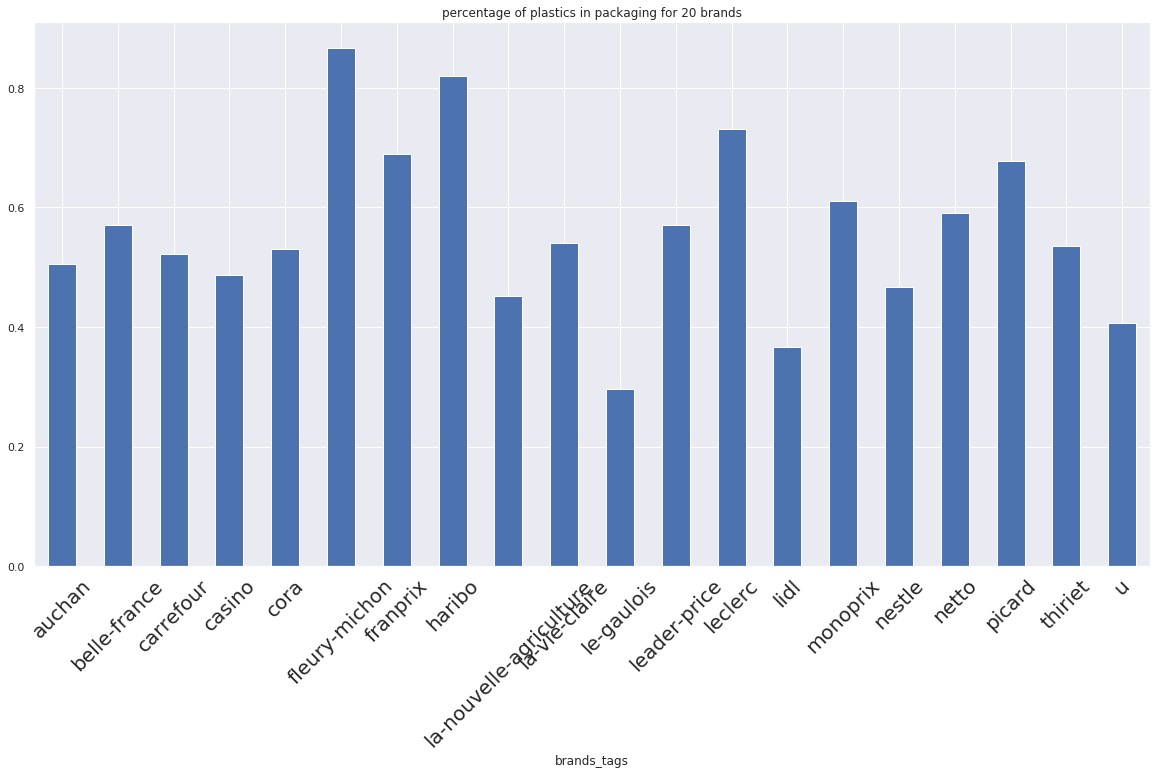

In [187]:
ax = data_major_brands_fr_cleaned_plastic_percentage.plot(kind="bar", figsize=(20,10), title= 'percentage of plastics in packaging for 20 brands')
ax.tick_params(axis='x', labelsize=20)
plt.xticks(rotation=45)

In [0]:
fig = ax.get_figure()
fig.savefig('/content/drive/My Drive/EPFL/ma1/ADA/Ada Project/french_plastics.png', bbox_inches = 'tight')

We can see an interesting result, giving the percentage of plastics in the different brands' packaging. This top 20 shows a full range of brands, from very ecological to not at all, in terms of packaging of course.

##USA

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

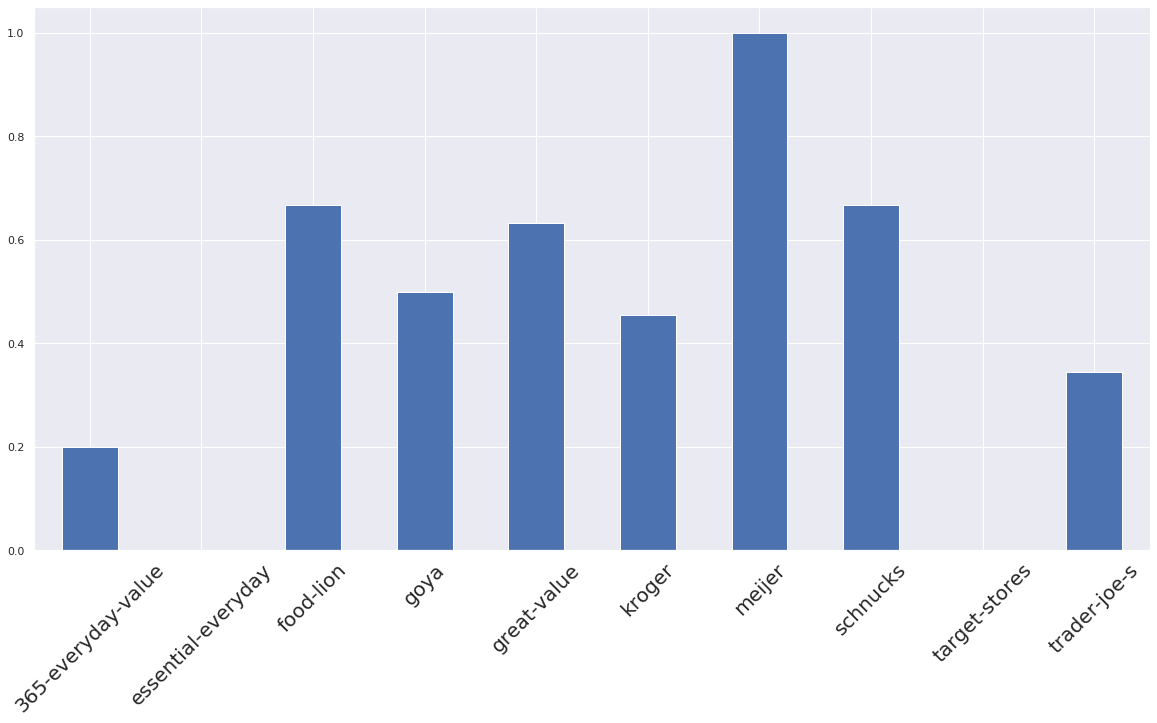

In [189]:
data_major_brands_us = data[data.brands_tags.isin(us_sample)]
data_major_brands_us_cleaned = data_major_brands_us[pd.notnull(data_major_brands_us['packaging'])]
data_major_brands_us_cleaned['packaging'] = data_major_brands_us_cleaned['packaging'].apply(lambda x: str(x).lower())
data_major_brands_us_cleaned_plastic = data_major_brands_us_cleaned[data_major_brands_us_cleaned['packaging'].apply(lambda x: fuzz.partial_ratio(x.lower(),"plastic")>60 or fuzz.partial_ratio(x.lower(),"kunststoff")>60 or fuzz.partial_ratio(x.lower(),"stück")>60)]
data_major_brands_us_cleaned_plastic = data_major_brands_us_cleaned_plastic.groupby('brands_tags').size()
data_major_brands_us_cleaned_plastic_percentage = data_major_brands_us_cleaned_plastic.sort_index().div(data_major_brands_us_cleaned.brands_tags.value_counts().sort_index(ascending = True))
ax_us = data_major_brands_us_cleaned_plastic_percentage.head(10).plot(kind="bar", figsize=(20,10))
ax_us.tick_params(axis='x', labelsize=20)
plt.xticks(rotation=45)

Surprisingly, we can note that none of the users that registered food from essential-everyday indicated the packaging type of the product, thus giving this result. Same for target-stores.

In [0]:
fig_us = ax_us.get_figure()
fig_us.savefig('/content/drive/My Drive/EPFL/ma1/ADA/Ada Project/us_plastics.png', bbox_inches = 'tight')

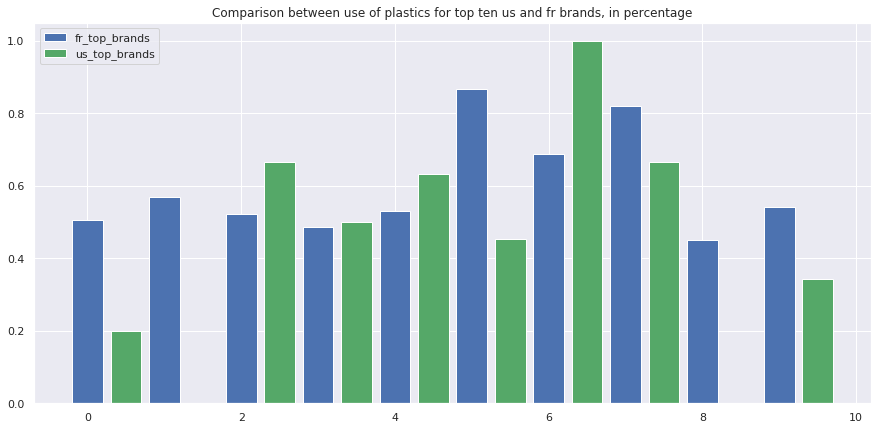

In [191]:
X = np.arange(10)
plt.figure(figsize=(15,7))
plt.bar(X + 0.0, data_major_brands_fr_cleaned_plastic_percentage.head(10), color = 'b', width = 0.4)
plt.bar(X + 0.5, data_major_brands_us_cleaned_plastic_percentage.head(10), color = 'g', width = 0.4)
plt.legend(['fr_top_brands', 'us_top_brands'])
#plt.xticks(X, sample_comp)
#plt.xticks(X + 0.5, data_major_brands_us_cleaned_plastic_percentage.sort_values(ascending=False).head(10).index)
#plt.xticks(rotation=45)
plt.title("Comparison between use of plastics for top ten us and fr brands, in percentage")
plt.show()

In [0]:
categories = data[['product_name','countries_en']].dropna()
categories_us = categories[categories['countries_en'] == 'United States']['product_name']
categories_fr = categories[categories['countries_en'] == 'France']['product_name']
categories_ch = categories[categories['countries_en'] == 'Switzerland']['product_name']

In [193]:
data['countries_en'].value_counts().sort_values(ascending = False)

France           379866
United States    101543
Spain             48959
Germany           26214
Switzerland       25182
                  ...  
Comoros               1
Lesotho               1
Liberia               1
Belize                1
England               1
Name: countries_en, Length: 157, dtype: int64

#Products trends

##Switzerland

In [194]:
topCategories_ch = categories_ch.value_counts()
topCategories_ch = topCategories_ch[topCategories_ch > 1]
topCategories_ch.index = topCategories_ch.index.str.lower()
topCategories_ch.head()

jus d'orange    31
mozzarella      30
jus de pomme    29
lait            22
lait entier     19
Name: product_name, dtype: int64

In [0]:
meats = pd.Series(['poulet', 'boeuf', 'veau', 'porc', 'mouton', 'agneau', 'chèvre', 'cheval', 'lapin', 'dinde'])
counts_ch = pd.Series([0,0,0,0,0,0,0,0,0,0])
i = 0
for m in meats:
  counts_ch[i] = topCategories_ch.index.str.contains(m,regex=False).sum()
  i = i + 1
counts_ch = counts_ch/counts_ch.sum()

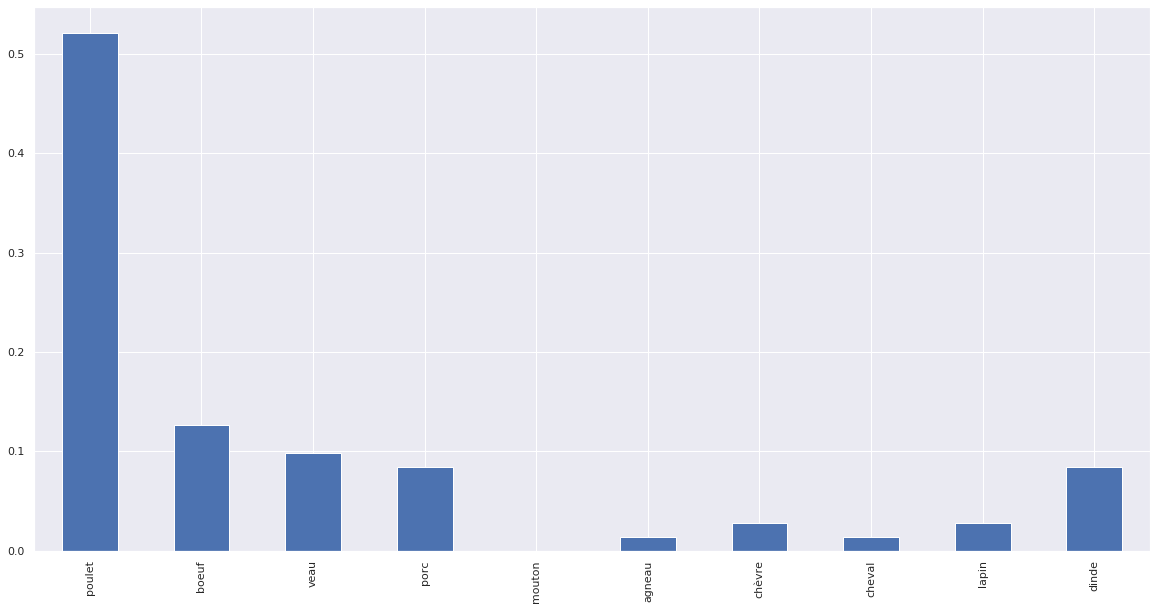

In [196]:
counts_ch.index = meats
plt.figure(figsize=(15,7))
counts_ch.plot(kind="bar", figsize=(20,10))

##France

In [197]:
topCategories_fr = categories_fr.value_counts()
topCategories_fr = topCategories_fr[topCategories_fr > 3]
topCategories_fr.index = topCategories_fr.index.str.lower()
topCategories_fr.shape[0]

8045

In [198]:
topCategories_fr.head(20)

jus de pomme           322
filet de poulet        242
jus d'orange           226
ketchup                174
saumon fumé            164
filets de poulet       160
pain complet           160
poulet                 158
spaghetti              153
mozzarella             149
merguez                148
jambon                 147
limonade               145
pois chiches           142
yaourt                 126
chipolatas             124
moutarde de dijon      123
terrine de campagne    114
escalope de dinde      113
pur jus de pomme       111
Name: product_name, dtype: int64

In [0]:
counts = pd.Series([0,0,0,0,0,0,0,0,0,0])
i = 0
for m in meats:
  counts[i] = topCategories_fr.index.str.contains(m,regex=False).sum()
  i = i + 1
counts = counts/counts.sum()

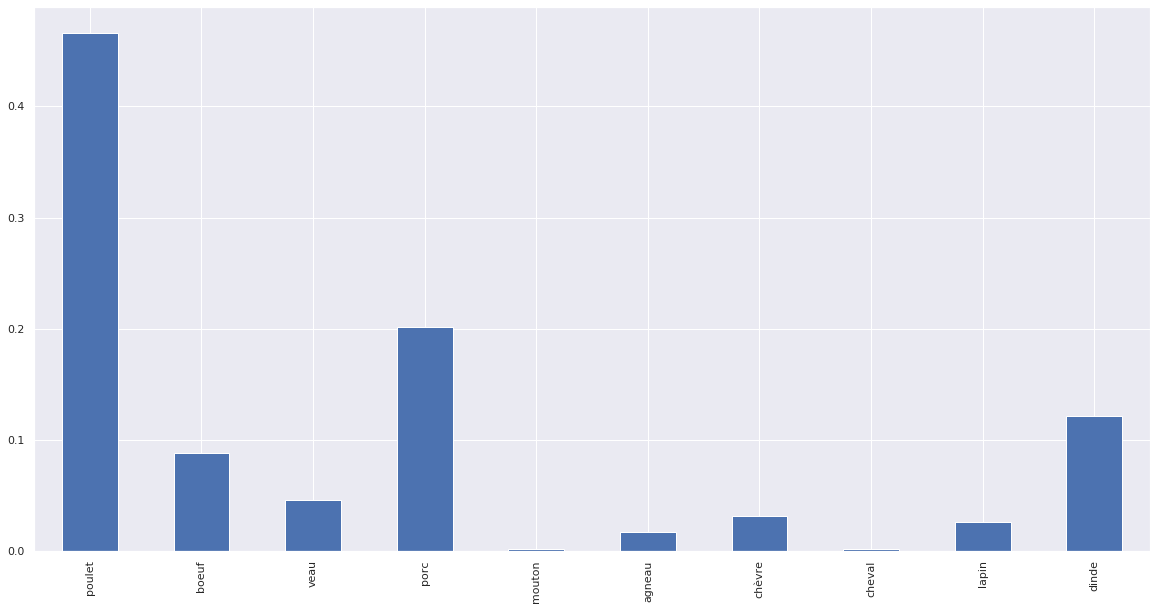

In [200]:
counts.index = meats
plt.figure(figsize=(15,7))
counts.plot(kind="bar", figsize=(20,10))

##United States

In [201]:
topCategories_us = categories_us.value_counts()
topCategories_us = topCategories_us[topCategories_us > 1]
topCategories_us.index = topCategories_us.index.str.lower()
topCategories_us.head(20)

ice cream              407
premium ice cream      220
salsa                  147
tomato sauce           127
cut green beans        127
apple sauce            114
pinto beans            110
greek nonfat yogurt    106
tomato ketchup         106
pasta sauce            105
chicken broth          104
black beans            102
soda                   100
cottage cheese          94
2% reduced fat milk     92
sweet peas              90
diced tomatoes          88
mixed vegetables        85
bbq sauce               81
greek yogurt            78
Name: product_name, dtype: int64

In [0]:
meats_us = pd.Series(['chicken', 'beef', 'veal', 'pork', 'mutton', 'lamb', 'goat', 'horse', 'rabbit', 'turkey'])
counts_us = pd.Series([0,0,0,0,0,0,0,0,0,0])
i = 0
for m in meats_us:
  counts_us[i] = topCategories_us.index.str.contains(m,regex=False).sum()
  i = i + 1
counts_us = counts_us/counts_us.sum()

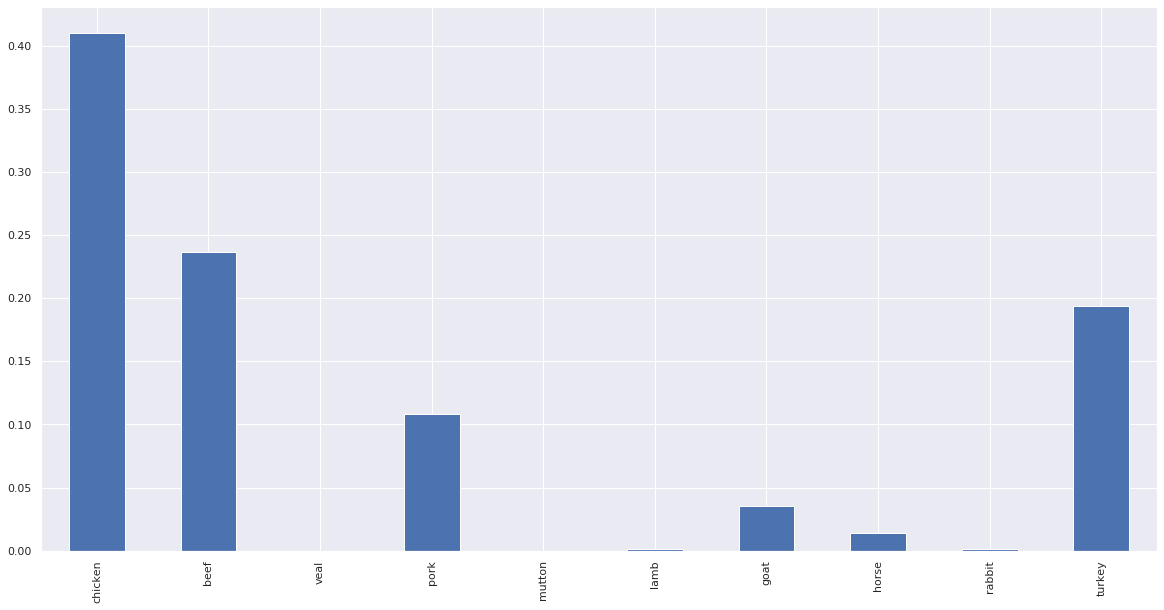

In [203]:
counts_us.index = meats_us
plt.figure(figsize=(15,7))
counts_us.plot(kind="bar", figsize=(20,10))

##Comparison between France, the US and Switzerland

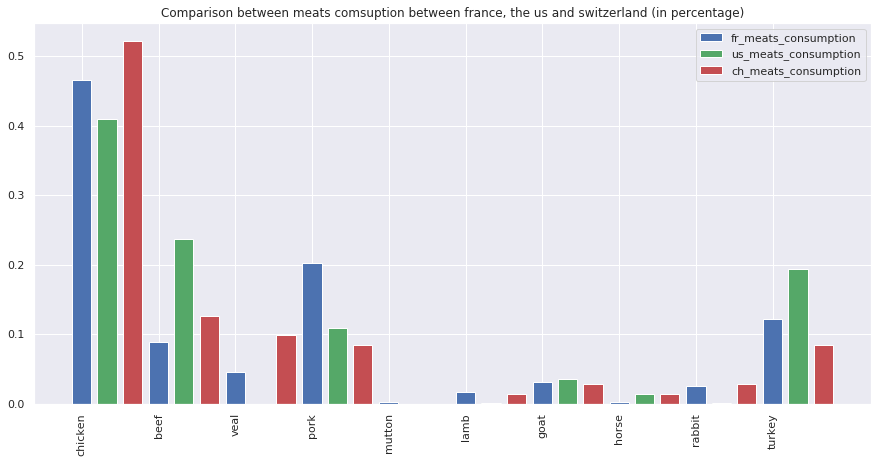

In [204]:
X = np.arange(10)

plt.figure(figsize=(15,7))
plt.bar(X + 0.0, counts, color = 'b', width = 0.25)
plt.bar(X + 0.33, counts_us, color = 'g', width = 0.25)
plt.bar(X + 0.66, counts_ch, color = 'r', width = 0.25)
plt.legend(['fr_meats_consumption', 'us_meats_consumption', 'ch_meats_consumption'])
plt.xticks(X, counts_us.index)
plt.xticks(rotation='vertical')
plt.title("Comparison between meats comsuption between france, the us and switzerland (in percentage)")
plt.show()

We can see with this graph, that there are little differences in meat consumption between the users of the database. However, we can see that us users buy more beef and more turkey. But french users buy more pork. We can also see that this dataset is representative of the overall dominance of chicken among meats. Indeed we know that chicken is by far the most popular meat in the world.